In [11]:
import os
import torch
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

#constant declaration
NUM_EPOCHS = 50
LEARNING_RATE = 5e-5
BATCH_SIZE = 32

In [12]:
# For full dataset, run tran_feature_selection notebook before this one
# For small subset of data, run tran_sample_preprocessing notebook beofore this one (ideal for testing model on CPU)

%store -r benign_flows  
%store -r mixed_flows
%store -r features

dim = len(features)

hyperparam_description = f'LR={LEARNING_RATE}, BatchSize={BATCH_SIZE}, #Features={len(features)}'

#TODO look into scalars vs normalizers --> https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer

normalizer = preprocessing.Normalizer(norm="l2")
normalized_train = normalizer.fit_transform(benign_flows[features]) #axis?
train_X = pd.DataFrame(normalized_train, columns = features)

normalized_test = normalizer.transform(mixed_flows[features])
test_X = pd.DataFrame(normalized_test, columns = features)
test_y = mixed_flows.is_attack
train_X

,count,avergae_packet_size,syn_packets,synack_packets,ack_packets,data_packets,total_bytes,flow_count
0,0.001263,0.003205,0.000000,0.000000,0.000959,0.000619,0.999993,0.000073
1,0.001367,0.002235,0.000012,0.000012,0.001009,0.000599,0.999996,0.000067
2,0.001457,0.002609,0.000019,0.000015,0.000997,0.000685,0.999995,0.000103
3,0.001236,0.002403,0.000006,0.000009,0.000936,0.000603,0.999996,0.000048
4,0.001213,0.003256,0.000004,0.000004,0.000921,0.000605,0.999993,0.000055
...,...,...,...,...,...,...,...,...
17275,0.004511,0.008239,0.000112,0.000112,0.002200,0.002013,0.999951,0.001044
17276,0.004303,0.008050,0.000139,0.000139,0.002151,0.001943,0.999954,0.000972
17277,0.003940,0.005138,0.000162,0.000162,0.001990,0.001320,0.999976,0.000914
17278,0.004771,0.009407,0.000180,0.000180,0.002160,0.002025,0.999939,0.001260


In [13]:
#dataset loading
train_tensor = torch.tensor(train_X.values.astype(np.float32))
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size = BATCH_SIZE, shuffle = True)
train_tensor

tensor([[1.2626e-03, 3.2050e-03, 0.0000e+00,  ..., 6.1915e-04, 9.9999e-01,
         7.2841e-05],
        [1.3666e-03, 2.2348e-03, 1.2229e-05,  ..., 5.9922e-04, 1.0000e+00,
         6.7259e-05],
        [1.4568e-03, 2.6093e-03, 1.9019e-05,  ..., 6.8467e-04, 9.9999e-01,
         1.0270e-04],
        ...,
        [3.9401e-03, 5.1384e-03, 1.6248e-04,  ..., 1.3201e-03, 9.9998e-01,
         9.1394e-04],
        [4.7710e-03, 9.4071e-03, 1.8004e-04,  ..., 2.0254e-03, 9.9994e-01,
         1.2603e-03],
        [3.9258e-03, 0.0000e+00, 9.1298e-05,  ..., 1.8716e-03, 9.9999e-01,
         0.0000e+00]])

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=dim, out_features=int(dim/2))
        self.enc2 = nn.Linear(in_features=int(dim/2), out_features=int(dim/4))
        self.enc3 = nn.Linear(in_features=int(dim/4), out_features=int(dim/8))
        
        # decoder 
        self.dec1 = nn.Linear(in_features=int(dim/8), out_features=int(dim/4))
        self.dec2 = nn.Linear(in_features=int(dim/4), out_features=int(dim/2))
        self.dec3 = nn.Linear(in_features=int(dim/2), out_features=dim)
        
    def forward(self, x):
        # relu alternative: torch.sigmoid
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        return x

In [15]:
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Autoencoder()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
#Training model

# Alternative loss functions - BCEWithLogitsLoss(), BCELoss()
loss_function = nn.MSELoss() # Switching from BCELoss 

train_loss = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data in train_loader:
        input_data = data.to(device=device)
        optimizer.zero_grad()
        output = net(input_data).to(device=device)                  # output is the reconstruced x 
        loss = loss_function(output, input_data).to(device=device)  # input_data should be the target variable
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    pickle.dump(net, open("model", 'wb'))
    
    if epoch % 5 == 0:
        print('Epoch {} of {}, Train Loss: {:.5f}'.format(
          epoch+1, NUM_EPOCHS, loss))
print("Completed training with final loss {:.5f}".format(train_loss[-1]))

Epoch 1 of 50, Train Loss: 0.13229
Epoch 6 of 50, Train Loss: 0.12500
Epoch 11 of 50, Train Loss: 0.12500
Epoch 16 of 50, Train Loss: 0.12500
Epoch 21 of 50, Train Loss: 0.12500
Epoch 26 of 50, Train Loss: 0.12500
Epoch 31 of 50, Train Loss: 0.12500
Epoch 36 of 50, Train Loss: 0.12500
Epoch 41 of 50, Train Loss: 0.12500
Epoch 46 of 50, Train Loss: 0.12500
Completed training with final loss 0.12500


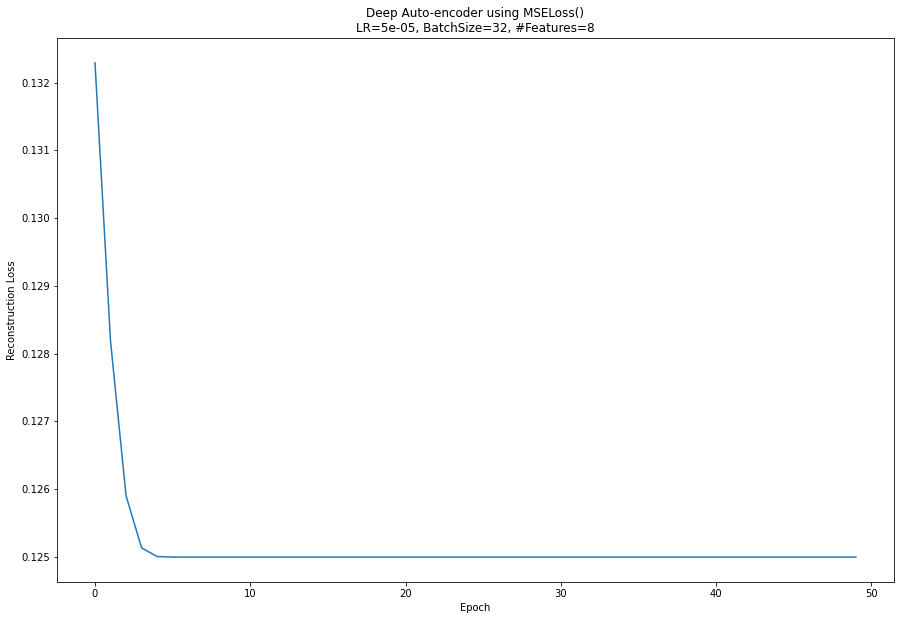

In [16]:
_, ax = plt.subplots(1,1,figsize=(15,10))
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
ax.set_title(f'Deep Auto-encoder using {loss_function}\n{hyperparam_description}')
ax.plot(train_loss)

In [17]:
# Calculate reconstruction loss for test partition (mixed flow data)
test_loss = []
net.eval()
test_tensor = torch.tensor(test_X.values.astype(np.float32))

with torch.no_grad():
    for i in range(len(test_X)):
        input = test_tensor[i].to(device=device)
        output = net(input).to(device=device)
        loss = loss_function(output, input).to(device=device)
        test_loss.append(loss.item())

In [18]:
fpr, tpr, thresholds = roc_curve(y_true=test_y.astype(int), y_score=test_loss, pos_label=1)
ranked_thresholds = sorted(list(zip(np.abs(tpr - fpr), thresholds, tpr, fpr)), key=lambda i: i[0], reverse=True)
_, attack_threshold, threshold_tpr, threshold_fpr = ranked_thresholds[0]
print(f"Selected Attack Threshold: {attack_threshold}")
print("Theshold yields TPR: {:.4f}, FPR: {:.4f}".format(threshold_tpr, threshold_fpr))

auc = roc_auc_score(y_true=test_y.astype(int),  y_score=test_loss)
print("AUC: {:.4f}".format(auc))

plt.figure(figsize=(10, 10))
plt.plot([0,1], [0,1], linestyle="--") # plot baseline curve
plt.plot(fpr, tpr, marker=".", label="Attack Threshold:{:.6f}\nTPR: {:.4f}, FPR:{:.4f}".format(attack_threshold, threshold_tpr, threshold_fpr))
plt.axhline(y=threshold_tpr, color='darkgreen', lw=0.8, ls='--')
plt.axvline(x=threshold_fpr, color='darkgreen', lw=0.8, ls='--')
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

Selected Attack Threshold: 1.1250014752149582
Theshold yields TPR: nan, FPR: 0.0000


/users/grad/fali/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

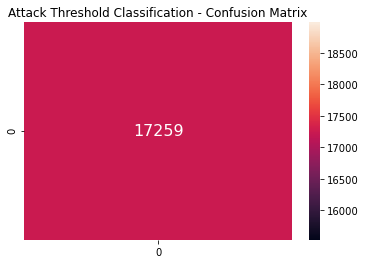

In [19]:
test_results = test_y.to_frame().astype(bool)
test_results['loss'] = pd.Series(test_loss, index=test_results.index)
test_results['is_attack_prediction'] = test_results.loss > attack_threshold

conf_matrix = confusion_matrix(test_results.is_attack, test_results.is_attack_prediction)
plt.figure()
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g')
plt.title('Attack Threshold Classification - Confusion Matrix')
print(classification_report(test_results.is_attack, test_results.is_attack_prediction, target_names=["benign", "attack"]))

/users/grad/fali/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


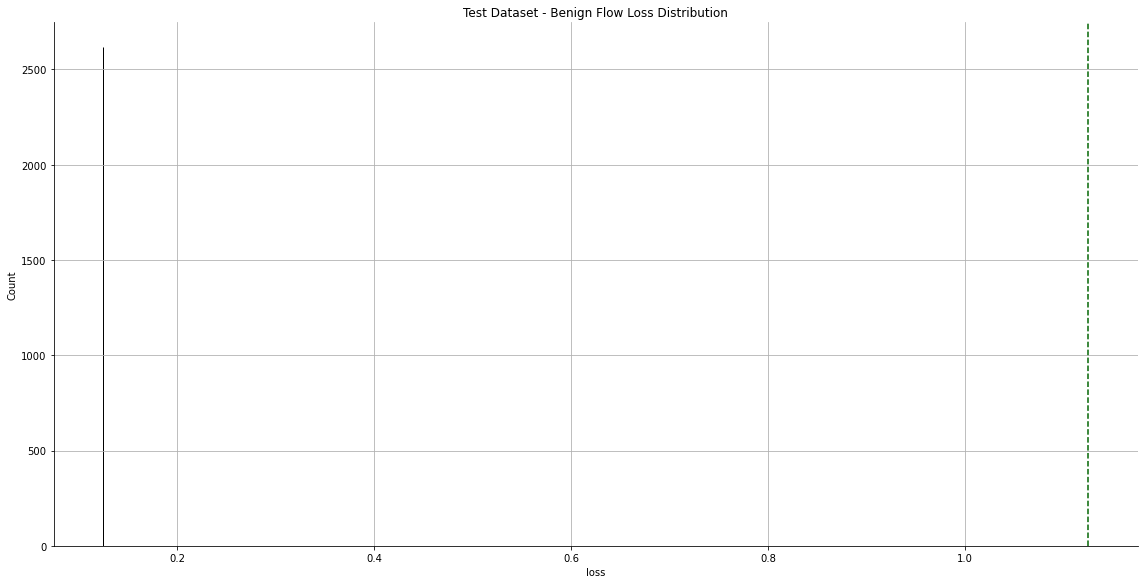

In [20]:
benign_loss = test_results[test_results['is_attack'] == False].loss
sns.displot(benign_loss, bins=100, kde=True, color='navy', height=8, aspect=2)
plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Test Dataset - Benign Flow Loss Distribution')
plt.grid(True)

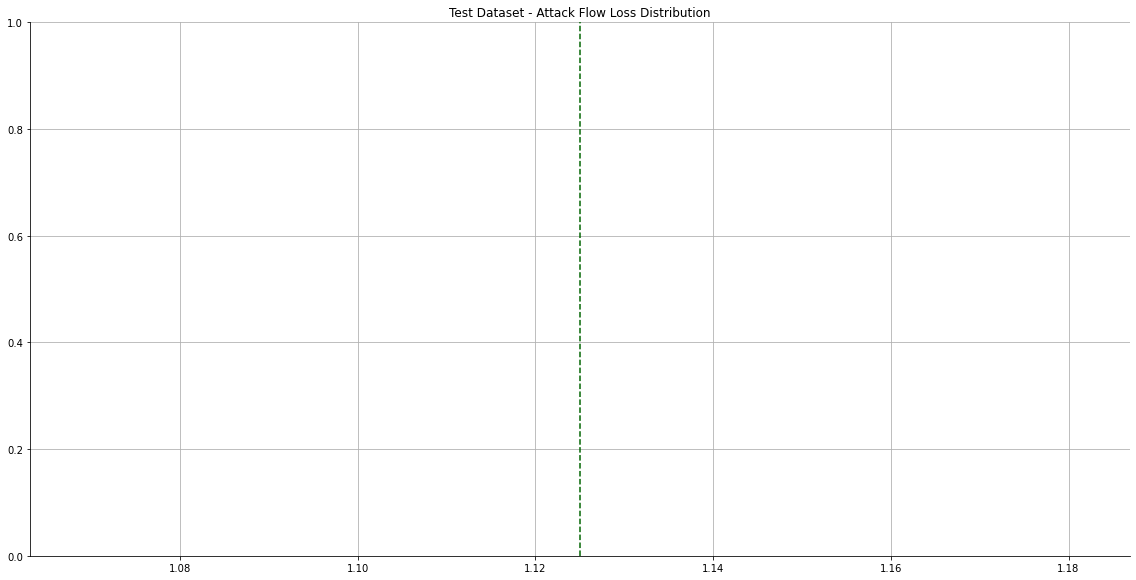

In [21]:
attack_loss = test_results[test_results['is_attack'] == True].loss
sns.displot(attack_loss, bins=100, kde=True, color='crimson', height=8, aspect=2)
plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Test Dataset - Attack Flow Loss Distribution')
plt.grid(True)

/users/grad/fali/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


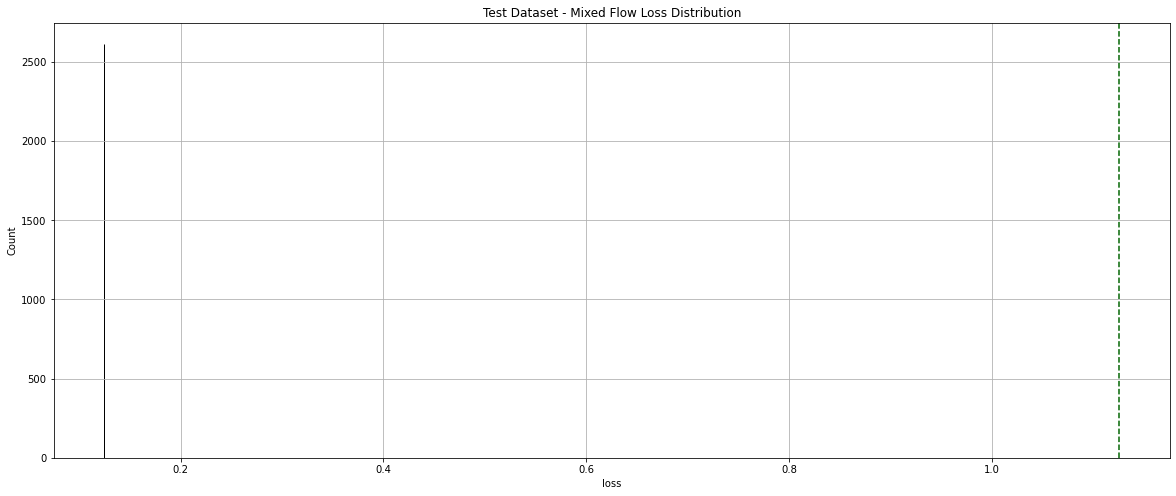

In [22]:
fig, ax = plt.subplots(figsize=(20, 8))
attack_loss = test_results[test_results['is_attack'] == True].loss
benign_loss = test_results[test_results['is_attack'] == False].loss
sns.histplot(benign_loss, ax=ax, bins=100, kde=True, color='navy', alpha=0.5)
sns.histplot(attack_loss, ax=ax, bins=100, kde=True, color='crimson', alpha=0.5)

plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Test Dataset - Mixed Flow Loss Distribution')
ax.grid(True)

In [23]:
# Calculating loss for training-set on trained model (for toubleshooting distributions)
post_train_loss = [] 
net.eval()
train_tensor = torch.tensor(train_X.values.astype(np.float32))

with torch.no_grad():
    for i in range(len(train_X)):
        input = train_tensor[i].to(device=device)
        output = net(input).to(device=device)
        loss = loss_function(output, input).to(device=device)
        post_train_loss.append(loss.item())

/users/grad/fali/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


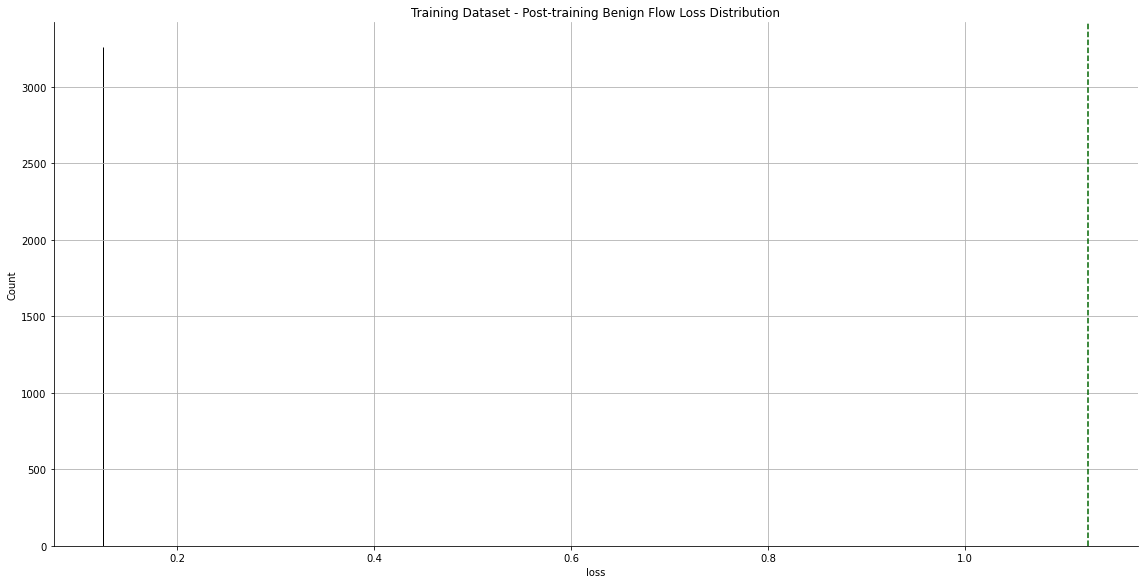

In [24]:
# Graph loss density for training set post training
post_train_results = pd.DataFrame({'is_attack': [False] * len(post_train_loss)})
post_train_results['loss'] = pd.Series(post_train_loss, index=post_train_results.index)
post_train_results['is_attack_prediction'] = post_train_results.loss > attack_threshold

sns.displot(post_train_results.loss, bins=100, kde=True, color='navy', height=8, aspect=2)
plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Training Dataset - Post-training Benign Flow Loss Distribution')
plt.grid(True)